# Algorithmic Trading: Pairs Trade Strategy

Integrante: Rodrigo Durán

El siguiente trabajo esta enfocado a realizar una estrategía de trading con señales estadísticas, más conocido como pairs trading.

En primer lugar se realiza una calibración de parámetros con datos historicos y la selección del par de equities optima.

En segundo lugar se mide el grado de overfitting de la calibración con un nuevo horizonte de datos y se efectua la estrategía con distintos parámetros.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf
import seaborn as sns; sns.set()
import statsmodels
from statsmodels.tsa.stattools import coint
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.odr import Model, Data, ODR
import statsmodels.api as sm
pd.options.mode.chained_assignment = None 

In [2]:
# Horizonte de Calibracion #
#start date
yearS=2014
monthS=1
dayS=1

#end date
yearE=2017
monthE=9
dayE=30

# Testing fuera de muestra #
#start date
yearS=2017
monthS=10
dayS=1

#end date
yearE=2018
monthE=10
dayE=30

El código de abajo muestra como se descargo los precios de las acciones bancarias transados IPSA, se eligio los bancos chilenos ya que historicamente los bancos suelen comportarse de la misma manera ej. alta correlation y cointegracion optima

In [3]:
"""chile = pdr.get_data_yahoo('CHILE.SN', 
                          start=datetime.datetime(yearS,monthS,dayS), 
                          end=datetime.datetime(yearE, monthE, dayE))


bci = pdr.get_data_yahoo('BCI.SN', 
                          start=datetime.datetime(yearS,monthS,dayS), 
                          end=datetime.datetime(yearE, monthE, dayE))

santander = pdr.get_data_yahoo('BSANTANDER.SN', 
                          start=datetime.datetime(yearS,monthS,dayS), 
                          end=datetime.datetime(yearE, monthE, dayE))

itau = pdr.get_data_yahoo('ITAUCORP.SN', 
                          start=datetime.datetime(yearS,monthS,dayS), 
                          end=datetime.datetime(yearE, monthE, dayE))
                          
#Exportar Data
chile.to_csv('banco_chile.csv')
bci.to_csv('bci.csv')
itau.to_csv('itau.csv')
santander.to_csv('santander.csv')"""

"chile = pdr.get_data_yahoo('CHILE.SN', \n                          start=datetime.datetime(yearS,monthS,dayS), \n                          end=datetime.datetime(yearE, monthE, dayE))\n\n\nbci = pdr.get_data_yahoo('BCI.SN', \n                          start=datetime.datetime(yearS,monthS,dayS), \n                          end=datetime.datetime(yearE, monthE, dayE))\n\nsantander = pdr.get_data_yahoo('BSANTANDER.SN', \n                          start=datetime.datetime(yearS,monthS,dayS), \n                          end=datetime.datetime(yearE, monthE, dayE))\n\nitau = pdr.get_data_yahoo('ITAUCORP.SN', \n                          start=datetime.datetime(yearS,monthS,dayS), \n                          end=datetime.datetime(yearE, monthE, dayE))\n                          \n#Exportar Data\nchile.to_csv('banco_chile.csv')\nbci.to_csv('bci.csv')\nitau.to_csv('itau.csv')\nsantander.to_csv('santander.csv')"

In [4]:
# Importar data
chile = pd.read_csv('banco_chile.csv',index_col = 0).dropna()
bci = pd.read_csv('bci.csv',index_col = 0).dropna()
itau = pd.read_csv('itau.csv',index_col = 0).dropna()
santander = pd.read_csv('santander.csv',index_col = 0).dropna()

In [5]:
# Precios de Cierre bancos chilenos transados en bolsa
itau_prices = itau[['Adj Close']].rename(index = str,columns={'Adj Close':'Itau'})
chile_prices = chile[['Adj Close']].rename(index = str,columns={'Adj Close':'Chile'})
bci_prices = bci[['Adj Close']].rename(index = str,columns={'Adj Close':'BCI'})
santander_prices= santander[['Adj Close']].rename(index = str,columns={'Adj Close':'Santander'})

In [6]:
# Matriz de cierre de precios
trading = pd.concat([bci_prices,santander_prices,itau_prices,chile_prices], axis=1,join = 'inner').dropna()

In [7]:
# Horizonte de tiempo calibracion # 2014-2017
trading_train = trading.iloc[:939,:]

# Horizonte de tiempo para testing fuera de muestra # 2017-2018
trading_test = trading.iloc[939:,:]

In [8]:
print('Cierre de Precios desde el 2014-2017')
print(trading_train.head())

Cierre de Precios desde el 2014-2017
                     BCI  Santander      Itau      Chile
Date                                                    
2014-01-02  21151.609375  24.096285  5.889181  51.473732
2014-01-03  21169.955078  24.119963  5.835715  51.515179
2014-01-06  21282.197266  24.096285  5.882105  51.625652
2014-01-07  21638.613281  23.993679  5.827066  51.694759
2014-01-08  21716.341797  24.198889  5.805837  51.950256


In [9]:
print('Cierre de Precios desde el 2017-2018')
print(trading_test.tail())

Cierre de Precios desde el 2017-2018
                     BCI  Santander   Itau      Chile
Date                                                 
2018-10-25  43254.699219  50.709999  6.496  96.650002
2018-10-26  42787.000000  50.680000  6.459  96.239998
2018-10-29  42930.000000  50.580002  6.364  95.570000
2018-10-30  42721.000000  50.080002  6.361  94.620003
2018-10-31  43760.000000  51.080002  6.450  96.410004


## Preselección de pares optimos


El primer paso es utilizar el análisis de correlación, se realizará para todas las combinaciones de equities posibles, donde cada uno de los pares de stock será preseleccionado si su coeficiente de correlación es
igual o mayor que 0.90.

                BCI  Santander      Itau     Chile
BCI        1.000000   0.948986  0.206004  0.942673
Santander  0.948986   1.000000  0.261890  0.967173
Itau       0.206004   0.261890  1.000000  0.218999
Chile      0.942673   0.967173  0.218999  1.000000


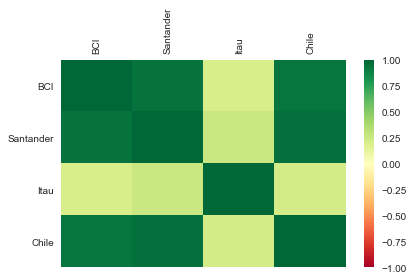

In [11]:
# Correlacion 
df_corr = trading_train.corr()

def visualize_data():
    print(df_corr.head())
    #takes only data (numbers) inside the corr matrix
    data =  df_corr.values
    fig = plt.figure()
    #1 by 1 in plot number one
    ax = fig.add_subplot(1,1,1)
    #customizing the plot showing the correlation in color
    #if theres negative correlation if stock goes up other goes down
    heatmap = ax.pcolor(data,cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0])+0.5,minor = False)
    ax.set_yticks(np.arange(data.shape[1])+0.5,minor = False)
    #errases any gaps from the graph
    ax.invert_yaxis()
    #moves ticks from xaxis to the top
    ax.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    #limit of the color limit of the heatmap of correlationmatrix
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    plt.show()

visualize_data()

Debido a estas correlaciones automaticamente descartamos el banco itau ya que la correlacion con los demas bancos es muy bajo para el filtro de nuestra estrategia

El segundo paso involucra utilizar el enfoque de cointegración para determinar cual es el par mas óptimo para ejecturá nuestra estrategía, este será probado en todos los pares de acciones preseleccionadas, que ya se seleccionaron en función de los resultados del enfoque de correlación. 

Un subconjunto de los pares de acciones se seleccionará adicionalmente si el valor de prueba de cointegración es igual o menor que -3.34, el cual es una cointegracion con 95% de intervalo de confianza.

In [12]:
coint_sanchile = coint(trading_train['Chile'],trading_train['Santander'])[0]
coint_bcichile = coint(trading_train['Chile'],trading_train['BCI'])[0]
coint_sanbci = coint(trading_train['BCI'],trading_train['Santander'])[0]
print('Cointegración Banco Chile vs Santander:',coint_sanchile)
print('Cointegración Banco Chile vs BCI:',coint_bcichile)
print('Cointegración BCI vs Santander:',coint_sanbci)

Cointegración Banco Chile vs Santander: -3.276245164277644
Cointegración Banco Chile vs BCI: -1.9054704758752108
Cointegración BCI vs Santander: -3.178876102345246


In [13]:
print('Correlacion Banco Chile vs Santander',df_corr.iloc[1,3])
print('Cointegración Banco Chile vs Santander:',coint_sanchile)

Correlacion Banco Chile vs Santander 0.9671732640478916
Cointegración Banco Chile vs Santander: -3.276245164277644


Dado los resultados obtenidos en las pruebas de correlacion y cointegracion, el par seleccionado es:
##### Banco de Chile - Santander
En el siguiente grafico se puede observar el comportamiento de los precios de cierre de las acciones de Banco de Chile y Santander:

Text(0.5,1,'Santander vs Chile')

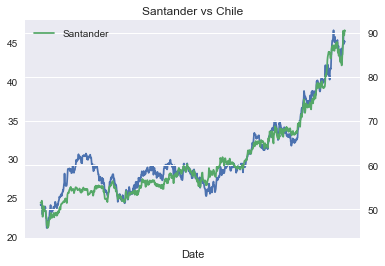

In [14]:
trading_train['Santander'].plot()
trading_train['Chile'].plot(secondary_y=True)
plt.legend(['Santander'])
plt.title('Santander vs Chile')

## In Sample - Training

Hay dos formas de encontrar la pendiente de una regresión $\beta$:

$
Ordinary \ Least \ Squares \ (OLS)
$

$
Total \ Least \ Squares \ (TLS)
$

Utilizamos TLS porque de esta forma, la elección de las acciones en los ejes se vuelve irrelevante,
debido a que el pendiente ($\beta$) se ajusta de mejor manera que por mínimos cuadrados ordinarios (OLS). Esto significa que independientemente de cual equity usemos como y o x, la pendiente siempre va ser la misma, lo que no ocurre con mínimos cuadrados.  

In [15]:
# Total Least Squares
def linear_func(B, x):
    return B[0]*x+B[1]
def TLS(x,y):
    linear=Model(linear_func)
    linreg = stats.linregress(x,y)
    dat = Data(x,y)
    od = ODR(dat, linear, beta0=linreg[0:2])
    out = od.run()
    return out.beta[0]

Text(0.5,1,'Spread Banco Chile vs Santander')

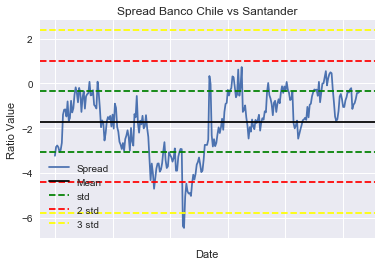

In [16]:
# Se calcula el parametro beta para la relacion Banco de Chile y Santander.
# y - mx = beta
beta_sanchile = TLS(trading_train['Chile'],trading_train['Santander'])

# Se aplicara una estrategia Long-Short en base al spread

residual_sanchile = trading_test['Santander'] - trading_test['Chile']*beta_sanchile

# La fuente generadora de señales a utilizar será una desviación estandar para tomar posiciones.

ratio = residual_sanchile
fig = plt.figure(1)
ax1 = fig.add_subplot(111,  ylabel='Ratio Value')
ratio.plot()
plt.axhline(ratio.mean(),color = 'black')
plt.axhline(ratio.mean()+np.std(ratio), color='green',linestyle='--')
plt.axhline(ratio.mean()+2*np.std(ratio), color='red',linestyle='--')
plt.axhline(ratio.mean()+3*np.std(ratio), color='yellow',linestyle='--')
plt.axhline(ratio.mean()-np.std(ratio), color='green',linestyle='--')
plt.axhline(ratio.mean()-2*np.std(ratio), color='red',linestyle='--')
plt.axhline(ratio.mean()-3*np.std(ratio), color='yellow',linestyle='--')
plt.legend(['Spread','Mean','std','2 std','3 std'])
plt.title('Spread Banco Chile vs Santander')  


La estrategía para tomar posición $larga \ Banco \ de \ Chile$ y $corta \ Santander$ se activará cuando el residuo alcance el umbral de una desviación estandar (linea verde superior) y se cerrará cuando esta vuelva a alcanzar su media (linea negra). Del mismo modo, ocurrira para la tomar posicion $corta \ Banco \ de \ Chile$ y $largo \ Santander$ cuando el residuo alcance menos una desviación estandar (linea verde inferior) y se cerrará cuando esta vuelva a alcanzar su media (linea negra).

También como medida de riesgo, cuando el residuo alcance 2 desviaciones estandar de la media (linea roja inferior y superior), se procedera a cerrar la posicion como medida de prevención, asumiendo una perdida dadas las posiciones tomadas.

In [17]:
def backtest(residuals,window):
    df1 = pd.DataFrame({'y':residual_sanchile}) 
    df1['spread'] = residual_sanchile
    
    ## Select window ##
    halflife = window
    
    ## mean and std ##
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    
    
    ## Estrategía de trading y stop loss ##
    entryLong = meanSpread - stdSpread
    entryShort = meanSpread + stdSpread
    dos_std_long = meanSpread - 2*stdSpread
    dos_std_short = meanSpread + 2*stdSpread
    
    ## Set up Long ##
    df1['long entry'] = (df1.spread <= entryLong) #& (df1.spread > dos_std_long)
    df1['long exit'] = (df1.spread == meanSpread) | (df1.spread <= dos_std_long)
    df1['num long'] = np.nan 
    df1.loc[df1['long entry'],'num long'] = 1 
    df1.loc[df1['long exit'],'num long'] = 0 
    df1['num long'][0] = 0
    df1['num long'] = df1['num long'].fillna(method='pad') 

    ## Set up Short ##
    df1['short entry'] = (df1.spread >= entryShort) #&  (df1.spread < dos_std_short)
    df1['short exit'] = (df1.spread == meanSpread) | (df1.spread >= dos_std_short)
    df1.loc[df1['short entry'],'num short'] = -1
    df1.loc[df1['short exit'],'num short'] = 0
    df1['num short'][0] = 0
    df1['num short'] = df1['num short'].fillna(method='pad')
    
    ## PnL ##
    df1['num total'] = df1['num long'] + df1['num short']
    df1['cambio spread'] = (df1['spread'] - df1['spread'].shift(1)) / df1['spread']
    df1['ret'] = df1['cambio spread'] * df1['num total'].shift(1)
    
    df1['ret acum'] = df1['ret'].cumsum()
    df1['ret acum'] = df1['ret acum'] + 1
    
    
    ## SORTINO ##
    df1['ret neg'] = np.nan

    for i in range (0,len(df1['cambio spread'])):
            if df1['cambio spread'].iloc[i] < 0.0:
                df1['ret neg'].iloc[i] = df1['cambio spread'][i]
            if df1['cambio spread'].iloc[i] > 0.0:
                df1['ret neg'].iloc[i] = np.nan 
    
    #df1['ret neg'] = df1['ret neg'].dropna()
    
    try:
        sortino = ((df1['ret'].mean() - 0.05)/ df1['ret neg'].std()) *np.sqrt(252)
    except ZeroDivisionError:
        sortino = 0.0 

    
    ## SHARP ##
    try:
        sharpe = ((df1['ret'].mean() - 0.05) / df1['ret'].std()) *np.sqrt(252)
    except ZeroDivisionError:
        sharpe = 0.0

    

    ## MAX DRAWDOWNS ##

    maximums = np.maximum.accumulate(df1['ret acum'].dropna().values)
    drawdowns = 1 - (df1['ret acum'].dropna().values) / maximums
    max_drawdowns = np.amax(drawdowns)
    
    
    ## NUM TRADES ##
    
    counters = 0 
    for i in range(1, len(df1['ret'])):
        if (df1['ret'].iloc[i] != 0.0) & (df1['ret'].iloc[i] != df1['ret'].iloc[i-1]):
            counters += 1
            
    
    
    ## HIT RATIO ##
    df1['hitratio'] = ""
    for i in range(1, len(df1['ret acum'])):
        if df1['ret acum'].iloc[i] > df1['ret acum'].iloc[i-1]:
            df1['hitratio'].iloc[i] = 'bueno'
        if df1['ret acum'].iloc[i] < df1['ret acum'].iloc[i-1]:
            df1['hitratio'].iloc[i] = 'malo'
    
    hit_ratio = (df1.hitratio.str.count("bueno").sum()/(df1.hitratio.str.count("malo").sum()+df1.hitratio.str.count("bueno").sum()))*100
    
    return df1['ret acum'], sharpe , sortino , max_drawdowns, counters ,hit_ratio 

A continuación se observa el comportamiento del spread calculado apartir del parametro $\beta$ estimado mediante TLS con el par seleccionado. También se observa la media movil y banda de desviaciones estandar moviles:

Tomar posición: $\mu \pm \sigma$

Stop loss: $\mu \pm 2 * \sigma$


La media y desviación estandar fueron calculadas con un rolling de 65 días. Por lo tanto el trading algoritmico comenzará a actuar 65 días desde el inicio de data disponible. 

Text(0.5,1,'Spread Banco Chile vs Santander')

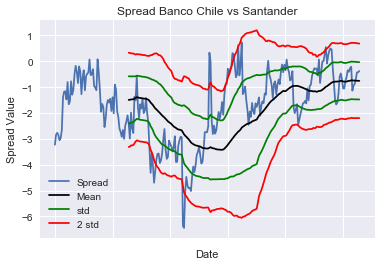

In [18]:
## PLOT ##

## Select window ##
halflife = 65
    
## mean and std ##
meanSpread = residual_sanchile.rolling(window=halflife).mean()
stdSpread = residual_sanchile.rolling(window=halflife).std()

ratio = residual_sanchile
cierre = meanSpread
stdsup = meanSpread + stdSpread
stdinf = meanSpread - stdSpread
stopstdsup = meanSpread + 2*stdSpread
stopstdinf = meanSpread - 2*stdSpread

fig = plt.figure(1)
ax1 = fig.add_subplot(111,  ylabel='Spread Value')
ratio.plot()
cierre.plot(color="black")
stdsup.plot(color="green")
stopstdsup.plot(color="red")
stdinf.plot(color="green")
stopstdinf.plot(color="red")
plt.legend(['Spread','Mean','std','2 std' ])
plt.title('Spread Banco Chile vs Santander')

In [19]:
at_res = ['Banco Chile / Santander']
at_res_col = ['Total Returns %','Sharpe Ratio', 'Sortino Ratio','Maximum Drawdown %','Number of Trades','Hit Ratio %']
test_df = pd.DataFrame(0, index=at_res_col, columns=at_res)

In [20]:
quant_test = backtest(residual_sanchile,65)

test_df.iloc[0,:] = quant_test[0][-1]
test_df.iloc[1,:] = quant_test[1]
test_df.iloc[2,:] = quant_test[2]
test_df.iloc[3,:] = quant_test[3]
test_df.iloc[4,:] = quant_test[4]
test_df.iloc[5,:] = quant_test[5]
test_df

,Banco Chile / Santander
Total Returns %,38.891896
Sharpe Ratio,1.145315
Sortino Ratio,0.178066
Maximum Drawdown %,2.840500
Number of Trades,76.000000
Hit Ratio %,47.368421


,Total Returns %,Sharpe Ratio,Sortino Ratio,Maximum Drawdown %,Number of Trades,Hit Ratio %
Banco Chile / Santander,38.891896,1.145315,0.178066,2.8405,76.0,47.368421


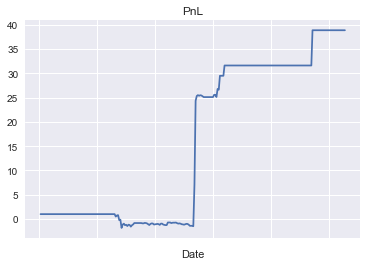

In [21]:
quant_test[0].plot()
plt.title('PnL') 
test_df.T

### Conclusiones

En resumen, el algoritmo de trading nos entrega un retorno a lo largo del periodo 2017-2018 de un $38.89\%$, lo que es un retorno muy bueno para este periodo. 

El ratio de sharp obtenido es de un 1.14 lo que significa que la prima por riesgo obtenida en base a su desviación estandar es aceptable dado que es mayor a 1. 

El ratio de sortino es bajo lo que indica que la volatilidad de mis rentabilidades negativas es baja, por lo que tener un maximum drawdown de $2.84\%$, ayuda a entender que dentro de mis rentabilidades negativas la mas baja fue de este valor y como contra ejemplo si el sortino ratio fuese mayor, existe la posibilidad de que con el algoritmo se pueda enfrentar a una perdida mayor en un siguiente testing dada la volatilidad de los retornos negativos. 

El número de trades fue significativo durante este periodo con un total de $76$ y de las veces que se opero, hubo una presicion del $47.36\%$.

Finalmente, para el periodo de tiempo testeado se tuvo un muy buen rendimiento de la estrategía utilizada, esto no asegura de que siempre se den estos resultados, por lo que es importante mantener una ventana con rolling adecuado y actualizado, que incluya los movimientos del spread que sean significativos para un futuro testeo en un nuevo horizonte de tiempo.

### Referencias

"High Frequency and Dynamic Pairs Trading Based on Statistical Arbitrage Using a Two-Stage Correlation and Cointegration Approach" by George J. Miao

"Better Hedge Ratios for Spread Trading" by Paul Teetor

"Pairs Trading, Convergence Trading, Cointegration" by Daniel Herlemont